# Load Data + Abridged Data Cleaning

This is a condensed/simplified data processing code from our Part 1. Visualizations have been removed along with steps we found to be un-useful for modeling. We utilize a set of features that we discovered to have the greatest correlations with our labels (from our EDA portion in part 1).

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



metadata = pd.read_csv('metadata.csv')
metadata.set_index('Sample_ID',inplace=True)


def impute_cols_by_skew(df, columns):
    for column_name in columns:
        sr_skew = df[column_name].skew()
        impute_value = None
        if sr_skew > 0:
            impute_value = df[column_name].mean()
        elif sr_skew < 0:
            impute_value = df[column_name].median()
        df[column_name].fillna(impute_value, inplace=True)

#metadata.dropna(axis=0, how='any', inplace=True, subset=['azm_sr', 'cfx_sr', 'cip_sr'])
metadata[['azm_sr', 'cfx_sr', 'cip_sr']] = metadata[['azm_sr', 'cfx_sr', 'cip_sr']].fillna(0.0)

useless_columns = ['Year', 'cro_sr', 'tet_sr', 'pen_sr']

metadata.drop(labels=useless_columns, axis=1, inplace=True)

metadata.drop_duplicates(inplace=True)

def remove_symbols_from_column(col):
    if col.dtype == object:  #check if strong
        return col.str.replace(r'[^a-zA-Z0-9]', '', regex=True)
    else:  #do nothing
        return col

metadata = metadata.apply(remove_symbols_from_column)

numeric_columns = ['Azithromycin','Ciprofloxacin','Ceftriaxone','Cefixime','Tetracycline','Penicillin','NG_MAST','Group','azm_mic','cip_mic','cro_mic','cfx_mic','tet_mic','pen_mic','log2_azm_mic','log2_cip_mic','log2_cro_mic','log2_cfx_mic','log2_tet_mic','log2_pen_mic']

for column in numeric_columns:
    metadata[column] = pd.to_numeric(metadata[column], errors='coerce', downcast="float") #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_numeric.html

metadata = pd.get_dummies(data=metadata, prefix="Encoded_Beta.lactamase", columns=['Beta.lactamase'], dtype=float)


train_inputs,test_inputs = train_test_split(metadata, test_size=0.20, random_state=42)   # partition and mix entries
#print(train_inputs.shape,":", test_inputs.shape)

targets = numeric_columns
impute_cols_by_skew(train_inputs, targets)
impute_cols_by_skew(test_inputs, targets)


normalizer = MinMaxScaler()

train_inputs[numeric_columns] = normalizer.fit_transform(train_inputs[numeric_columns])
test_inputs[numeric_columns] = normalizer.fit_transform(test_inputs[numeric_columns])




#Best columns obtained from EDA step
best_columns = [
    'Group', 'azm_mic', 'log2_azm_mic', 'log2_cip_mic', 'cip_mic', 'cro_mic', 
    'cfx_mic', 'log2_cro_mic', 'log2_cfx_mic', 'Ciprofloxacin', 'Cefixime', 
    'Tetracycline', 'Penicillin', 'log2_tet_mic', 'log2_pen_mic'
]





/tmp/ipykernel_35162/3693957775.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column_name].fillna(impute_value, inplace=True)
/tmp/ipykernel_35162/3693957775.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

### Our cleaned data for modelling

We are focusing on one of the 3 labels for now. All code works with swapping to the other labels

In [7]:
label_bank = ['azm_sr', 'cfx_sr', 'cip_sr']
label_columns = ['azm_sr']

y_train = train_inputs[label_columns]
y_test = test_inputs[label_columns]

X_train = train_inputs[best_columns]
X_test = test_inputs[best_columns]



X_train.head()
y_train.head()

,azm_sr
Sample_ID,
16933_2#60,0.0
16933_2#61,0.0
10625_6#93,0.0
8727_5#76,1.0
17428_6#28,0.0


### Eval Functions

In [8]:
def plot_predictions(y_test, y_pred):

    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(y_test)), y_test, label='Actual', color='blue', marker='o')
    plt.scatter(range(len(y_pred)), y_pred, label='Predicted', color='red', marker='x')
    plt.yticks([0, 1.0])
    
    plt.title('CLASSIFICATION - Predictions vs Ground Truth (1 or 0)')
    plt.ylabel('Super Resistance')
    
    plt.legend()
    
    plt.grid(True)

    plt.show()



#Thresholding for classification
def threshold(y_pred):
    for i, v in enumerate(y_pred):
        if v > 0.5:
            y_pred[i] = 1.0
        else:
            y_pred[i] = 0.0


def eval_classification(y_true, y_pred):

    threshold(y_pred)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

    plot_predictions(y_test, y_pred)


    return metrics


In [9]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2490, 15)
(2490, 1)
(623, 15)
(623, 1)


# 1. KNN 

Tune with # of neighbors

/home/harveykw/miniconda3/envs/tf_elr/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


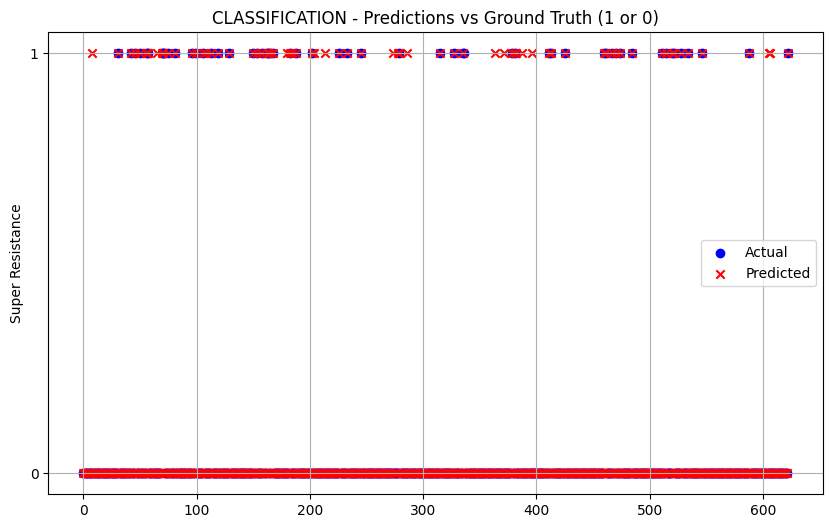

{'Accuracy': 0.9646869983948636, 'Precision': 0.9714201181687093, 'Recall': 0.9646869983948636, 'F1 Score': 0.9666768580091213}


In [10]:
from sklearn.neighbors import KNeighborsClassifier

def knn():

    model = KNeighborsClassifier(n_neighbors=5)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print(eval_classification(y_test, y_pred))
    


knn()


# 2. Naive Bayes

/home/harveykw/miniconda3/envs/tf_elr/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


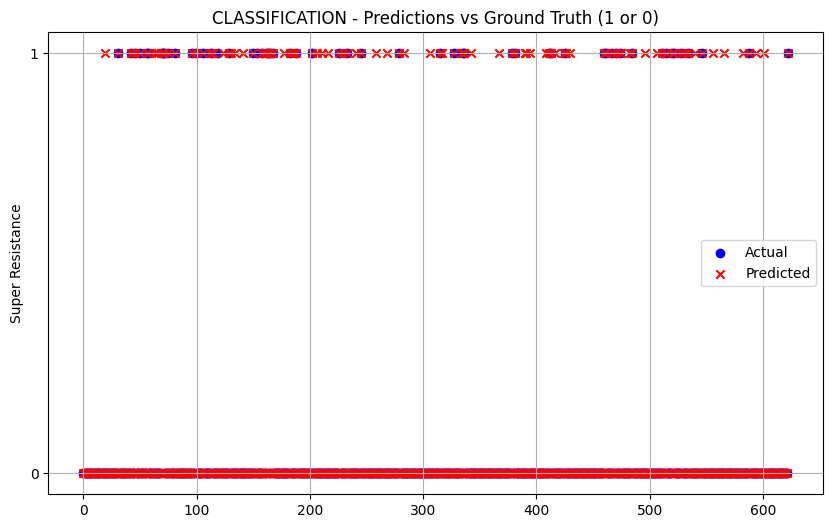

{'Accuracy': 0.9197431781701445, 'Precision': 0.9545507880062374, 'Recall': 0.9197431781701445, 'F1 Score': 0.9298824221512605}


In [11]:
from sklearn.naive_bayes import GaussianNB

def naive_bayes():
   
    model = GaussianNB()

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print (eval_classification(y_test, y_pred))

naive_bayes()

# 3. Logistic Regression

Tune with # of iterations

/home/harveykw/miniconda3/envs/tf_elr/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/harveykw/miniconda3/envs/tf_elr/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/harveykw/miniconda3/envs/tf_elr/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set t

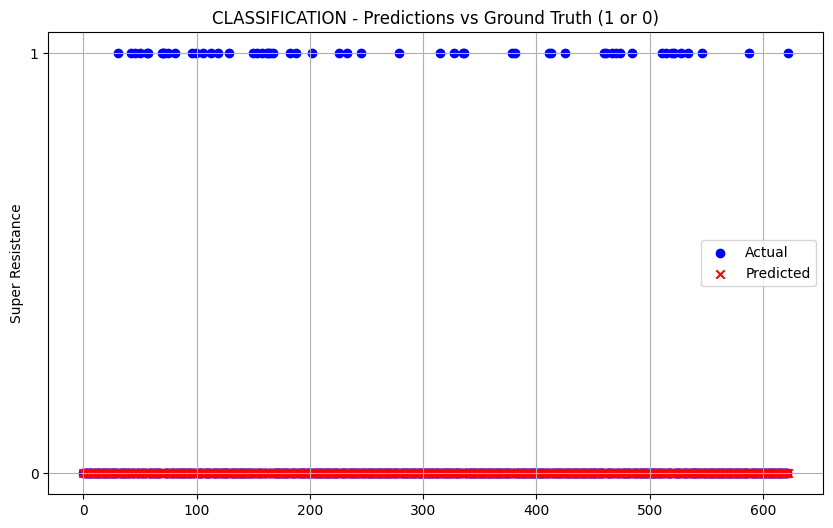

{'Accuracy': 0.9117174959871589, 'Precision': 0.8312287924890951, 'Recall': 0.9117174959871589, 'F1 Score': 0.8696146729147041}


In [12]:
from sklearn.linear_model import LogisticRegression

def logistic_regression():
   
    model = LogisticRegression(max_iter = 5)

    model.fit(X_train, y_train)


    y_pred = model.predict(X_test)

    print(eval_classification(y_test, y_pred))

logistic_regression()

# 4. Support Vector Machine

Tune with # of iterations

/home/harveykw/miniconda3/envs/tf_elr/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/harveykw/miniconda3/envs/tf_elr/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


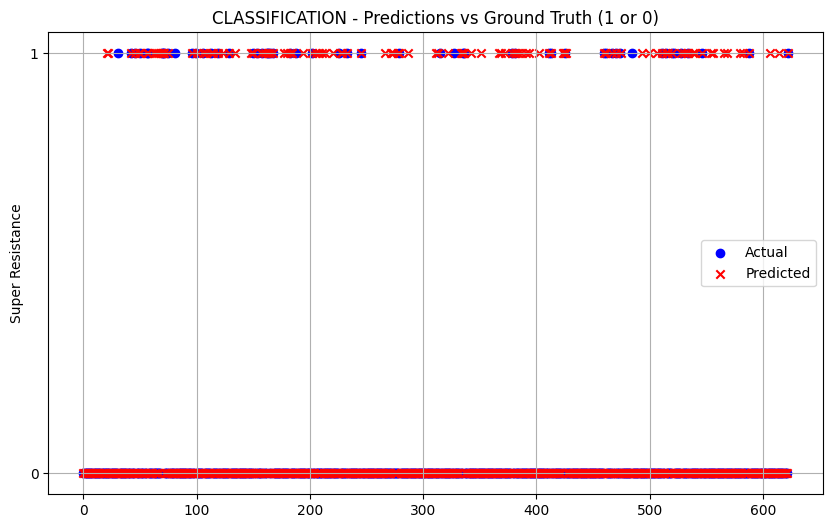

{'Accuracy': 0.8731942215088283, 'Precision': 0.9249012043216656, 'Recall': 0.8731942215088283, 'F1 Score': 0.8911026539938595}


In [13]:
from sklearn.svm import SVC


def svm():
   
    svm_model = SVC(max_iter = 10)

    svm_model.fit(X_train, y_train)

    y_pred = svm_model.predict(X_test)

    print(eval_classification(y_test, y_pred))

svm()

# 5. Neural Network

Courtesy of Keras

Tune with changing # of hyperparams (architecture, epochs, etc)

2024-10-18 00:46:42.308819: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-18 00:46:42.481033: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-18 00:46:42.481065: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-18 00:46:42.483403: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-18 00:46:42.483436: I tensorflow/compile

Epoch 1/10


2024-10-18 00:46:44.121886: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-10-18 00:46:44.301930: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fad29057ab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-18 00:46:44.301962: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-10-18 00:46:44.346644: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-18 00:46:44.414529: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-10-18 00:46:44.630908: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

78/78 [==============================] - 1s 3ms/step - loss: 0.2940 - accuracy: 0.8916
Epoch 2/10
78/78 [==============================] - 0s 3ms/step - loss: 0.0981 - accuracy: 0.9538
Epoch 3/10
78/78 [==============================] - 0s 2ms/step - loss: 0.0405 - accuracy: 0.9896
Epoch 4/10
78/78 [==============================] - 0s 2ms/step - loss: 0.0394 - accuracy: 0.9851
Epoch 5/10
78/78 [==============================] - 0s 2ms/step - loss: 0.0244 - accuracy: 0.9912
Epoch 6/10
78/78 [==============================] - 0s 2ms/step - loss: 0.0353 - accuracy: 0.9839
Epoch 7/10
78/78 [==============================] - 0s 2ms/step - loss: 0.0188 - accuracy: 0.9940
Epoch 8/10
78/78 [==============================] - 0s 2ms/step - loss: 0.0422 - accuracy: 0.9859
Epoch 9/10
78/78 [==============================] - 0s 2ms/step - loss: 0.0092 - accuracy: 0.9992
Epoch 10/10
20/20 [==============================] - 0s 763us/step


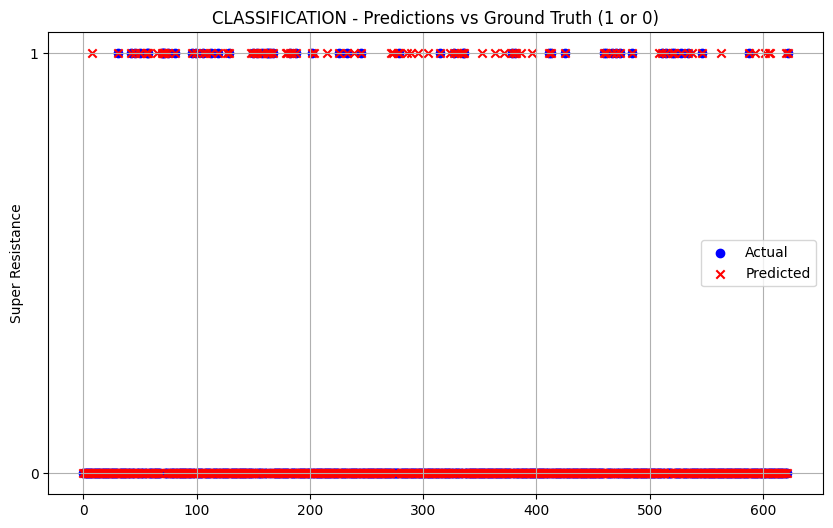

{'Accuracy': 0.9373996789727127, 'Precision': 0.963372152590417, 'Recall': 0.9373996789727127, 'F1 Score': 0.9444795706511183}


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


def build_architecture(input_shape):
  
    model = Sequential()
    
    model.add(Dense(8, input_shape=(input_shape,), activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation='sigmoid')) #Sigmoid activation for binary classification. Simple task so no need for the whole linear-last + manual sigmoid for numeric integrity.
    
    model.compile(optimizer=Adam(learning_rate=0.1), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

def neural_network():
    epochs = 10
    
    columns = X_train.shape[1]
    model = build_architecture(columns)

    model.fit(X_train, y_train, epochs=epochs, batch_size=32)

    y_pred = model.predict(X_test)

    print(eval_classification(y_test, y_pred))

neural_network()